In [1]:
from scLENS import scLENS
import pandas as pd
from torch import device as torch_device
from torch.cuda import is_available as cuda_available
import umap
import umap.plot
from glob import glob
import numpy as np
import os
from matplotlib import pyplot as plt

/home/khlab/miniconda3/envs/sclens-py/lib/python3.11/site-packages/tqdm_joblib/__init__.py:4: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm
/home/khlab/miniconda3/envs/sclens-py/lib/python3.11/site-packages/numba/np/ufunc/dufunc.py:346: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/home/khlab/miniconda3/envs/sclens-py/lib/python3.11/site-packages/numba/np/ufunc/dufunc.py:346: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/home/khlab/miniconda3/envs/s

Load the data to be used

In [2]:
p_dir = 'data/'

files_ = sorted(glob(p_dir+"/*.csv.gz"))
f = files_[4]

tmp_df = pd.read_csv(f)
y_true = tmp_df['cell']
df = tmp_df.drop('cell', axis=1)
df.index = y_true
df

,STK40,GBP5,SLAMF1,SMIM4,ARAP2,CNOT6L,KIAA0020,PIP4K2A,KAT6B,STAMBPL1,...,RPS18,RPL3,RPS6,TMSB4X,B2M,RPL13A,RPL10,RPS2,RPL13,MALAT1
cell,,,,,,,,,,,,,,,,,,,,,
b-cells,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,30.0,19.0,18.0,14.0,15.0,35.0,32.0,36.0,33.0,82.0
b-cells,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,15.0,20.0,16.0,10.0,10.0,28.0,28.0,30.0,27.0,43.0
b-cells,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,31.0,34.0,30.0,24.0,31.0,41.0,36.0,34.0,35.0,61.0
b-cells,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,26.0,21.0,24.0,21.0,14.0,32.0,31.0,34.0,35.0,40.0
b-cells,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9.0,11.0,11.0,15.0,3.0,18.0,13.0,24.0,16.0,38.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
regulatory-t,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,25.0,22.0,29.0,24.0,33.0,23.0,28.0,46.0,27.0,34.0
regulatory-t,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,10.0,22.0,22.0,18.0,31.0,20.0,20.0,24.0,32.0,17.0
regulatory-t,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,10.0,18.0,15.0,24.0,12.0,12.0,8.0,13.0,24.0


scLENS enables GPU computation, implemented through pyTorch. Device can be specified in initiation

In [3]:
device = torch_device('cuda:0' if cuda_available() else 'cpu')
sclens = scLENS(device=device)
sclens

Data can be fed into the scLENS object in two ways: either through the preprocess() function, which preprocesses the data and saves the clean data; or feed it into the fit() or fit_transform() function, in which case the data will not be preprocessed

The preprocess() function does the following in order:
1) Remove cells expressing less than *min_genes_per_cell* genes, and genes expressed in less than *min_cells_per_gene* cells
2) L1 normalize along each cell
3) Log scale the data
4) Z-score normalization along each gene
5) L2 normalize along each cell

In [4]:
%%time
sclens = scLENS(device=device)
sclens.preprocess(df, min_genes_per_cell=0, min_cells_per_gene=0)

Cell names are not unique, resetting cell names
Removed 0 cells and 0 genes in QC
CPU times: user 129 ms, sys: 138 ms, total: 267 ms
Wall time: 194 ms


,0,1,2,3,4,5,6,7,8,9,...,4793,4794,4795,4796,4797,4798,4799,4800,4801,4802
0,-0.143848,-0.128509,-0.180857,-0.146289,-0.166526,-0.182724,-0.165740,-0.160238,-0.147530,-0.145631,...,1.889642,-0.049349,-0.576040,-1.139774,-0.968717,1.479672,0.431748,0.748825,0.056999,2.412688
1,-0.146707,-0.131282,-0.183900,-0.149223,-0.169601,-0.185767,-0.168677,-0.163262,-0.150396,-0.148544,...,-0.312704,0.598384,-0.497400,-1.460185,-1.363746,1.129991,0.519284,0.627605,-0.135441,0.665279
2,-0.157587,-0.141831,-0.195480,-0.160388,-0.181300,-0.197343,-0.179853,-0.174769,-0.161303,-0.159626,...,0.415115,0.665534,-0.218642,-0.910223,-0.298248,0.479208,-0.562805,-0.871523,-1.110026,0.220684
3,-0.139088,-0.123894,-0.175791,-0.141405,-0.161408,-0.177660,-0.160850,-0.155204,-0.142758,-0.140783,...,0.993488,0.130982,0.135690,-0.354782,-1.097760,0.815548,0.148495,0.342733,0.142310,0.016082
4,-0.116902,-0.102382,-0.152177,-0.118638,-0.137550,-0.154052,-0.138060,-0.131738,-0.120516,-0.118183,...,-0.377948,0.121883,-0.208122,0.475472,-1.650776,1.008257,-0.507823,1.469112,-0.288576,1.474031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
773,-0.132431,5.563928,-0.168705,-0.134573,-0.154249,-0.170576,-0.154011,-0.148162,-0.136084,-0.134001,...,1.359080,0.681209,1.272268,0.378042,1.273666,0.001783,0.268141,2.367893,-0.302231,-0.033987
774,-0.119861,-0.105251,-0.155326,-0.121674,-0.140732,-0.157201,-0.141099,-0.134867,-0.123482,6.361846,...,-1.022309,0.984598,0.594071,-0.084633,1.338676,-0.082642,-0.443188,-0.019526,0.719898,-0.807247
775,-0.086488,-0.072892,-0.119805,-0.087427,-0.104844,-0.121690,-0.106817,-0.099569,-0.090025,-0.087201,...,-1.149255,0.272499,1.562343,0.828825,2.035263,0.142654,-0.158062,-0.923852,-0.258656,0.559613
776,-0.098555,5.792223,-0.132649,-0.099810,-0.117820,-0.134530,-0.119213,-0.112332,-0.102123,-0.099494,...,-1.654307,-0.303341,-0.857256,2.546515,2.996142,0.179422,0.118758,-1.293137,-0.595222,0.401443


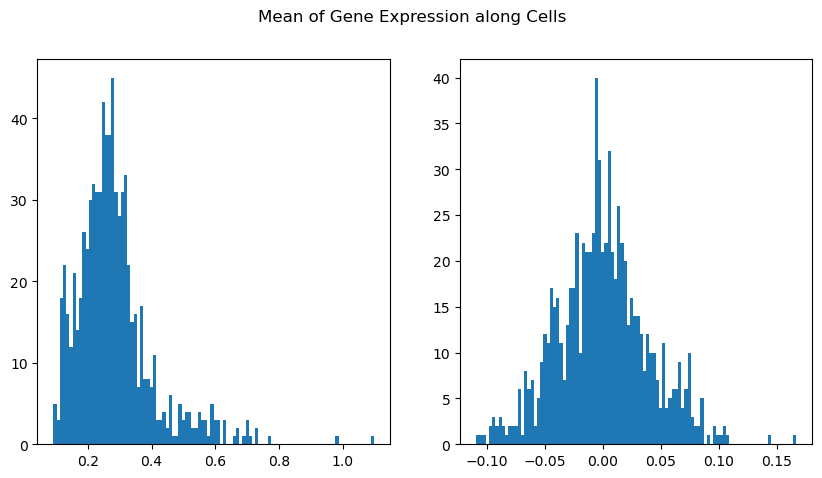

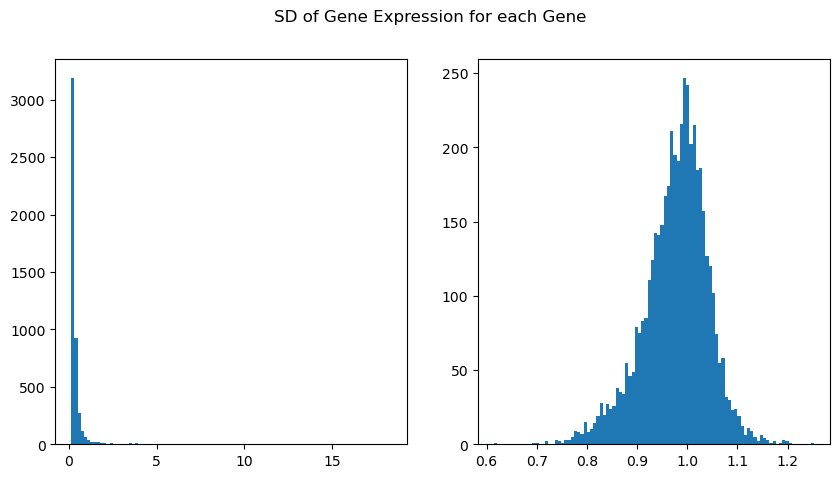

In [5]:
sclens.plot_preprocessing()

With fit_transform(), scLENS fits to the data, saving the robust components, and returns the projection of the training data to the robust components. For test data, the transform() function could be used, which projects the input data without fitting to it

scLENS adopts a modified version of PCA explained in https://arxiv.org/abs/1810.03602 and implemented in the Randomly python package (https://github.com/RabadanLab/randomly). The steps performed in Randomly can be outlined as:
1) Create randomized data matrix by permutating data points along cells
2) Perform PCA on the original and randomized data, creating two sets of principal components
3) Calculate the Marchenko-Pastur distribution and Tracy-Widom critical eigenvalue
4) Select principal components above the Tracy-Widom threshold, the signal components

scLENS builds on this method by selecting only the components robust from small perturbations among the signal components. scLENS does the following:
1) Perform PCA on the original data
2) Construct *n_rand_matrix* random binary matrices, each having *sparsity* sparsity
3) Create *n_rand_matrix* perturbed data matrices by adding the random binary matrices to the original data
4) Perform PCA on the perturbed data matrices
5) Calculate the correlation between the signal components found in the original data and the signal components found in the perturbed data
6) Select signal components with correlation above *threshold*, the robust components

Note that *sparsity* is automatically calculated by default. Specifying a number during initialization skips the sparsity calculation step

/home/khlab/scLENSpy/scLENS/PCA.py:180: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  plot = sns.distplot(self.L,


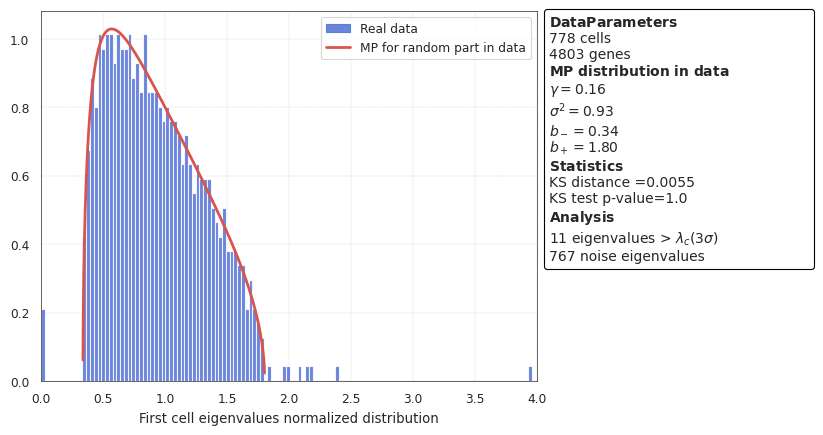

sparsity_th: 0.12087976014304841
Min(corr): [0.22521946 0.22537899], sparsity: 0.999, add_ilen: (3736,)
Min(corr): [0.19289212 0.19461169], sparsity: 0.998, add_ilen: (7473,)
Min(corr): [0.16535588 0.17006025], sparsity: 0.997, add_ilen: (11210,)
Min(corr): [0.16161208 0.16180182], sparsity: 0.996, add_ilen: (14946,)
Min(corr): [0.14824426 0.15160289], sparsity: 0.995, add_ilen: (18683,)
Min(corr): [0.1399973  0.14061872], sparsity: 0.994, add_ilen: (22420,)
Min(corr): [0.13325489 0.14193828], sparsity: 0.993, add_ilen: (26157,)
Min(corr): [0.13419574 0.13523797], sparsity: 0.992, add_ilen: (29893,)
Min(corr): [0.12264589 0.1261149 ], sparsity: 0.991, add_ilen: (33630,)
Min(corr): [0.12634883 0.12715702], sparsity: 0.99, add_ilen: (37367,)
Min(corr): [0.12309743 0.12358933], sparsity: 0.989, add_ilen: (41104,)
Min(corr): [0.11955409 0.12499558], sparsity: 0.988, add_ilen: (44840,)
Min(corr): [0.12445136 0.12473629], sparsity: 0.987, add_ilen: (48577,)
Min(corr): [0.11888921 0.11970459]

100%|██████████| 20/20 [00:02<00:00,  8.34it/s]

CPU times: user 7.09 s, sys: 163 ms, total: 7.26 s
Wall time: 5.36 s


In [6]:
%%time
X_transform = sclens.fit_transform(plot_mp=True)

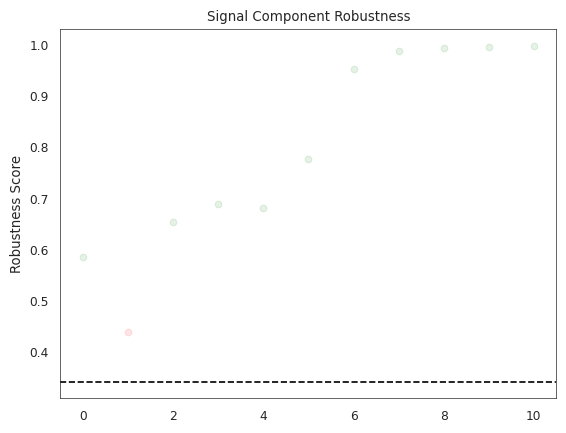

In [7]:
sclens.plot_robust_score()

In [8]:
sclens.sparsity

0.986

The projected data can be visualized in any mapping of your choice

<Axes: >

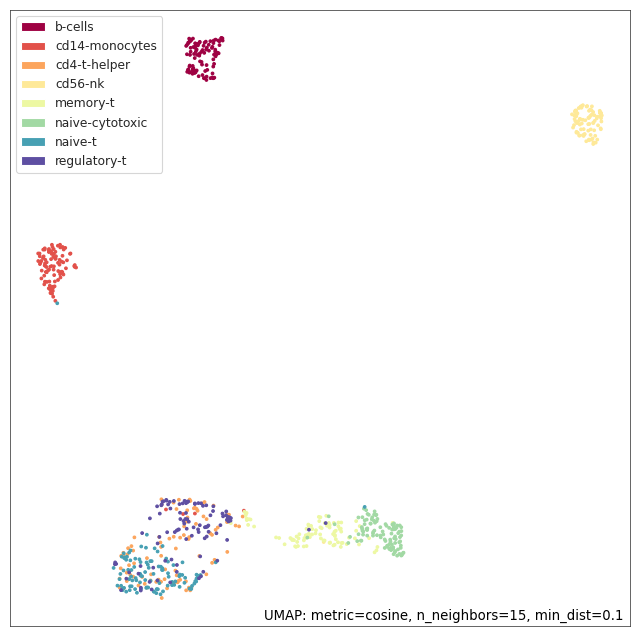

In [9]:
mapper = umap.UMAP(metric='cosine').fit(X_transform)
umap.plot.points(mapper, labels=y_true)

**sclens.Clustering** provides a clustering function, **find_clusters()**, along with an automatic resolution parameter selectors, including [multiK](https://github.com/perou-lab/MultiK) or [chooseR](https://github.com/rbpatt2019/chooseR).


In [10]:
from scLENS.clustering import find_clusters

ChooseR
--- 


In [11]:
sclens.cluster(method='chooseR',device="cpu") # Use all available CPU for parallel computation
sclens.chooseR_resolution

ChooseR: 100%|██████████| 40/40 [07:45<00:00, 11.65s/it]


,res,n_clusters,low_med,med
3,0.30,6,0.954138,0.998396
2,0.25,5,0.937629,1.000000
1,0.20,5,0.988192,1.000000
0,0.15,5,0.993332,1.000000
23,0.10,5,0.992782,1.000000
15,0.05,5,0.994897,1.000000


<Axes: >

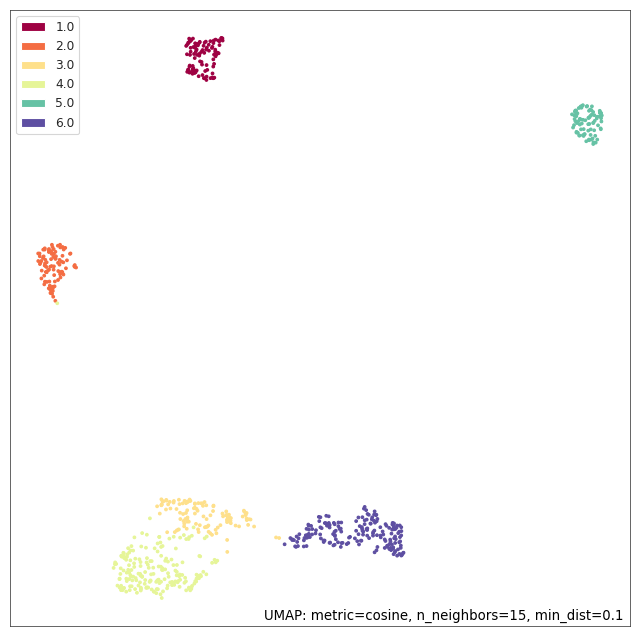

In [13]:
chooseR_result = sclens.optim_label
umap.plot.points(mapper, labels=chooseR_result)


MultiK
--

In [14]:
sclens.cluster(method='multiK',device="cpu")
sclens.multiK_resolution

  0%|          | 0/100 [00:00<?, ?it/s]

sparsity_th: 0.13248496685055552
Min(corr): [0.23690201 0.24455621], sparsity: 0.999, add_ilen: (2604,)
Min(corr): [0.2068273  0.20989542], sparsity: 0.998, add_ilen: (5209,)
Min(corr): [0.19215705 0.19541285], sparsity: 0.997, add_ilen: (7814,)
Min(corr): [0.17713894 0.17987148], sparsity: 0.996, add_ilen: (10419,)
Min(corr): [0.15973202 0.16244677], sparsity: 0.995, add_ilen: (13024,)
Min(corr): [0.13770514 0.15426253], sparsity: 0.994, add_ilen: (15629,)
Min(corr): [0.15096256 0.15553598], sparsity: 0.993, add_ilen: (18234,)
Min(corr): [0.15115143 0.15146583], sparsity: 0.992, add_ilen: (20839,)
Min(corr): [0.14610196 0.14745772], sparsity: 0.991, add_ilen: (23444,)
Min(corr): [0.14523251 0.14748365], sparsity: 0.99, add_ilen: (26049,)
Min(corr): [0.13605726 0.13900922], sparsity: 0.989, add_ilen: (28654,)
Min(corr): [0.13320757 0.13730376], sparsity: 0.988, add_ilen: (31259,)
Min(corr): [0.12683327 0.13502773], sparsity: 0.987, add_ilen: (33864,)
Min(corr): [0.13187108 0.13339472],

100%|██████████| 100/100 [00:26<00:00,  3.85it/s]


Optimal resolutions: [np.float64(1.2500000000000002), np.float64(0.9500000000000001)]


[np.float64(1.2500000000000002), np.float64(0.9500000000000001)]

MultiK provides multiple resolution parameters that produce robust results, allowing you to choose a single parameter to generate a corresponding label.

In [15]:
multiK_result = find_clusters(sclens.X_transform,res=sclens.multiK_resolution[-1])


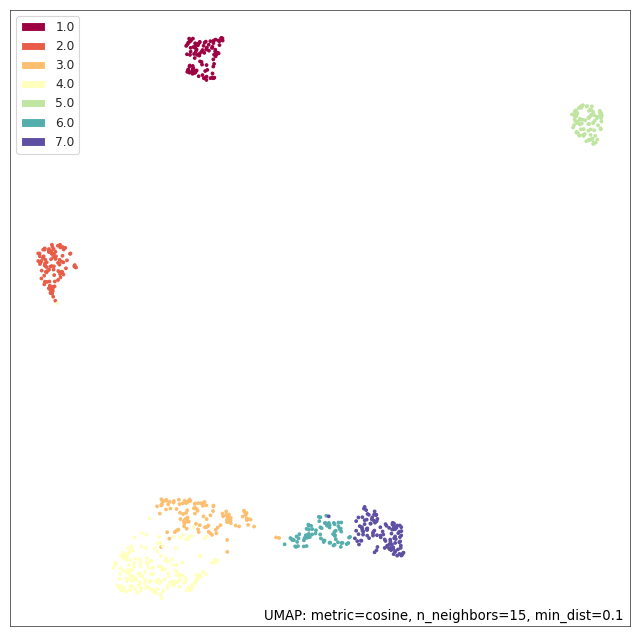

In [16]:
umap.plot.points(mapper, labels=multiK_result)
plt.show()


Save as AnnData
--

In [17]:
adata = sclens._return_anndata()
adata

/home/khlab/miniconda3/envs/sclens-py/lib/python3.11/functools.py:909: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)


AnnData object with n_obs × n_vars = 778 × 4803
    obs: 'chooseR_label', 'multiK_label_1.2500000000000002', 'multiK_label_0.9500000000000001'
    obsm: 'X_pca_sclens'
    layers: 'counts'

In [18]:
adata.write_h5ad("out.h5ad")